## Goal
preprocess wav,midi into ingestible format, line up onsets

mp3 -> wav -> stft/cqt -> matrix[num_onsets][frame_size/sequence length][freq_bins]

midi -> piano_roll[num_onsets][note_range]

num_onsets = batch size?
sequence length depends on the sampling rate (most sr 16000)
bin size is frequency resolution

In [31]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

import collections
import datetime
# import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional


In [32]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
SAMPLING_RATE = 16000
CONTEXT_WINDOW_ROWS = 88
HOP_LENGTH = 512

CQT_SLICE_RADIUS_IN_PIXELS = 2
CQT_SLICE_OFFSET_IN_PIXELS = 3
CQT_SLICE_WIDTH_IN_PIXELS = 1 + 2 * CQT_SLICE_RADIUS_IN_PIXELS


In [33]:
# data_dir = pathlib.Path('data/SMD_raw')
data_dir = '../data/SMD_raw'
mid_filenames = glob.glob(str(data_dir + '**/*.mid*'))
wav_filenames = glob.glob(str(data_dir + '**/*.mp3*')) #tk

print('Number of mid files:', len(mid_filenames))
print('Number of wav files:', len(wav_filenames))

Number of mid files: 50
Number of wav files: 50


# wav

In [34]:
def lame_process(input_file, output_file):
    '''
    Converts a single MP# file to WAV format using LAME decoder
    param input_file: path to an input MP3 file
    param output_file: path to save the output WAV file
    '''
    os.system(f'lame --decode --quiet "{input_file}" "{output_file}"')


In [35]:
def convert_mp3_to_wav(input_path, output_path):
    """
    Convert all MP3 files in a directory or a single MP3 file to WAV format
    param input_path: Path to the directory containing MP3 files
    param output_path: Path to save the converted WAV files to
    """
    if os.path.isdir(input_path):
        input_files = [file for file in os.listdir(input_path) if file.lower().endswith('.mp3')]
        for file_name in input_files:
            print(f'Processing {input_path}/{file_name}')
            output_file = os.path.splitext(file_name)[0] + '.wav'
            lame_process(os.path.join(input_path, file_name), os.path.join(output_path, output_file))
    else:
        lame_process(input_path, output_path)

In [36]:
convert_mp3_to_wav('../data/SMD_raw', "../data/wav")

Processing ../data/SMD_raw/Haydn_Hob017No4_003_20090916-SMD.mp3
Processing ../data/SMD_raw/Chopin_Op026No1_003_20100611-SMD.mp3
Processing ../data/SMD_raw/Bartok_SZ080-01_002_20110315-SMD.mp3
Processing ../data/SMD_raw/Brahms_Op010No2_003_20090916-SMD.mp3
Processing ../data/SMD_raw/Rachmaninoff_Op036-03_007_20110315-SMD.mp3
Processing ../data/SMD_raw/Brahms_Op005-01_002_20110315-SMD.mp3
Processing ../data/SMD_raw/Bach_BWV888-02_008_20110315-SMD.mp3
Processing ../data/SMD_raw/Chopin_Op010-03_007_20100611-SMD.mp3
Processing ../data/SMD_raw/Liszt_AnnesDePelerinage-LectureDante_002_20090916-SMD.mp3
Processing ../data/SMD_raw/Bach_BWV849-01_001_20090916-SMD.mp3
Processing ../data/SMD_raw/Chopin_Op028-04_003_20100611-SMD.mp3
Processing ../data/SMD_raw/Chopin_Op028-01_003_20100611-SMD.mp3
Processing ../data/SMD_raw/Mozart_KV398_002_20110315-SMD.mp3
Processing ../data/SMD_raw/Chopin_Op066_006_20100611-SMD.mp3
Processing ../data/SMD_raw/Haydn_HobXVINo52-01_008_20110315-SMD.mp3
Processing ../dat

In [ ]:

#base minimum frequency off of midi min freq? 
#need to iron out the inputs for the cqt 
def wav_to_spectrogram(wav_file, hop_length = 4096, fmin = 65.4, n_bins = 48, window_size = 7):
    """
    Converts a wav file into a tensor input for transformer model
    param wav: path to a wav file 
    """
    y, sr = librosa.load(wav_file)
    spectrogram = librosa.cqt(y, sr = sr, hop_length = hop_length, fmin = fmin, n_bins = n_bins) 
    
    print(spectrogram.shape) #(num_freq_bins, num_time_frames)
    spectrogram = spectrogram.T #transpose spectrogram to get right order for transformer
    spectrogram = librosa.amplitude_to_db(np.abs(spectrogram), ref = np.max) #convert to dB scale 
    minDB = np.min(spectrogram)
    
    print(f'Minimum: {np.min(spectrogram)}, Maximum: {np.max(spectrogram)}, Mean: {np.mean(spectrogram)}') 
    spectrogram = np.pad(spectrogram, ((window_size//2,window_size//2),(0,0)), 'constant', constant_values=minDB)  
    print(spectrogram.shape)

    windows = []
    for i in range(spectrogram.shape[0] - window_size + 1):
        w = spectrogram[i:i + window_size, :]
        windows.append(w)
    
    x = np.array(windows)
    print(f'padded spectrogram and windowed shape: {x.shape}')

    #plot_spectrogram(spectrogram_db, sr)
    return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, sr):
    """
    Creates a visualization of a spectrogram, for testing purpose
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CQT Spectrogram')
    plt.tight_layout()
    plt.show()

In [4]:
wav_sample_file = wav_filenames[0]
print(wav_sample_file)

../data/SMD_raw/testing_Bach_BWV849-01_001_20090916-SMD.wav


In [5]:
def compute_cqt(y):
    """
    Computes the CQT representation of a wav file
    """
    cqt = np.abs(librosa.cqt(y, sr=SAMPLING_RATE, n_bins=CONTEXT_WINDOW_ROWS,
                           hop_length=HOP_LENGTH))
    return cqt

In [6]:
def get_all_cqts(wavPath, outputDir):
    """
    Converts a WAV file to a CQT representation and a pianoroll representation
    """
    cqt = compute_cqt(wav_sample_file)

    print("Saving CQT for " + wav_sample_file)

    tot_time = cqt.shape[1]
    radius = CQT_SLICE_RADIUS_IN_PIXELS
    offset = CQT_SLICE_OFFSET_IN_PIXELS

    onsets = np.array(range(radius, tot_time-offset-radius-1, 2*radius+1)) 
    slice_indices = np.array([(onset+offset-radius, onset+offset+radius+1) for onset in onsets])
    h5_name = os.path.join(outputDir, piece_id) + ".h5"

    with h5py.File(h5_name, "w") as hf:
        hf.create_dataset("cqt", data=cqt)
        # hf.create_dataset("onsets", data=onsets)
        # hf.create_dataset("slice_indices", data=slice_indices)

    return

# mid

In [43]:
mid_sample_file = mid_filenames[0]
print(mid_sample_file)

../data/SMD_raw/Beethoven_Op031No2-03_002_20090916-SMD.mid


In [42]:
pm_list = []
for f in mid_sample_file: 
    pm = pretty_midi.PrettyMIDI(f)
    pm_list.append(f)

print(pm_list)


IsADirectoryError: [Errno 21] Is a directory: '.'

In [47]:
pm = pretty_midi.PrettyMIDI(mid_sample_file)

AttributeError: 'PrettyMIDI' object has no attribute 'type'

In [9]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [10]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=77, note_name=F5, duration=0.1729
1: pitch=69, note_name=A4, duration=0.4510
2: pitch=76, note_name=E5, duration=0.1500
3: pitch=74, note_name=D5, duration=0.0885
4: pitch=50, note_name=D3, duration=0.1615
5: pitch=57, note_name=A3, duration=0.0552
6: pitch=65, note_name=F4, duration=0.0510
7: pitch=62, note_name=D4, duration=0.2927
8: pitch=69, note_name=A4, duration=0.2646
9: pitch=77, note_name=F5, duration=0.1688


In [11]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [12]:
raw_notes = midi_to_notes(mid_sample_file)
raw_notes.head()



,pitch,start,end,step,duration
0,69,0.268750,0.719792,0.000000,0.451042
1,77,0.432292,0.605208,0.163542,0.172917
2,76,0.571875,0.721875,0.139583,0.150000
3,50,0.719792,0.881250,0.147917,0.161458
4,74,0.744792,0.833333,0.025000,0.088542


In [13]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A4', 'F5', 'E5', 'D3', 'D5', 'A3', 'D4', 'F4', 'A4', 'F5'],
      dtype='<U3')

In [14]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)


In [15]:
# def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
#   # Use librosa's specshow function for displaying the piano roll
#   librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
#                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
#                             fmin=pretty_midi.note_number_to_hz(start_pitch))

# plt.figure(figsize=(8, 4))
# plot_piano_roll(pm, 56, 70)

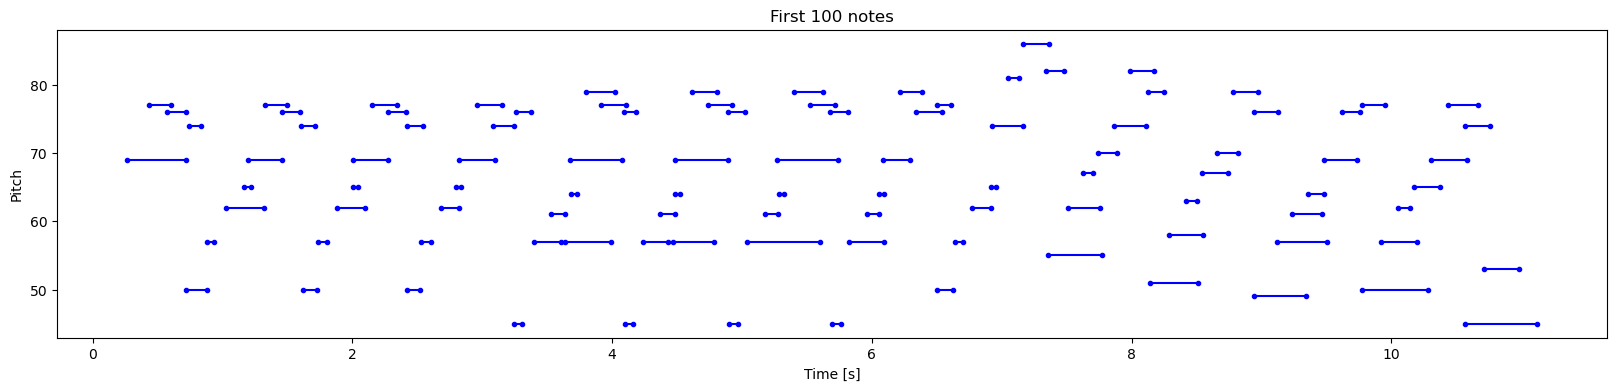

In [16]:
plot_piano_roll(raw_notes, count=100)

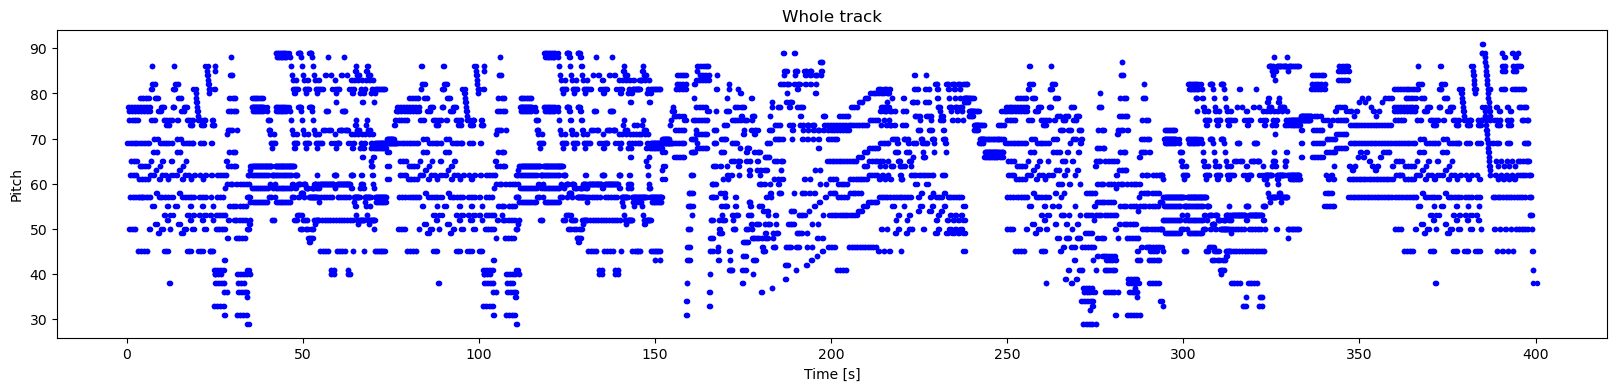

In [17]:
plot_piano_roll(raw_notes)

In [18]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

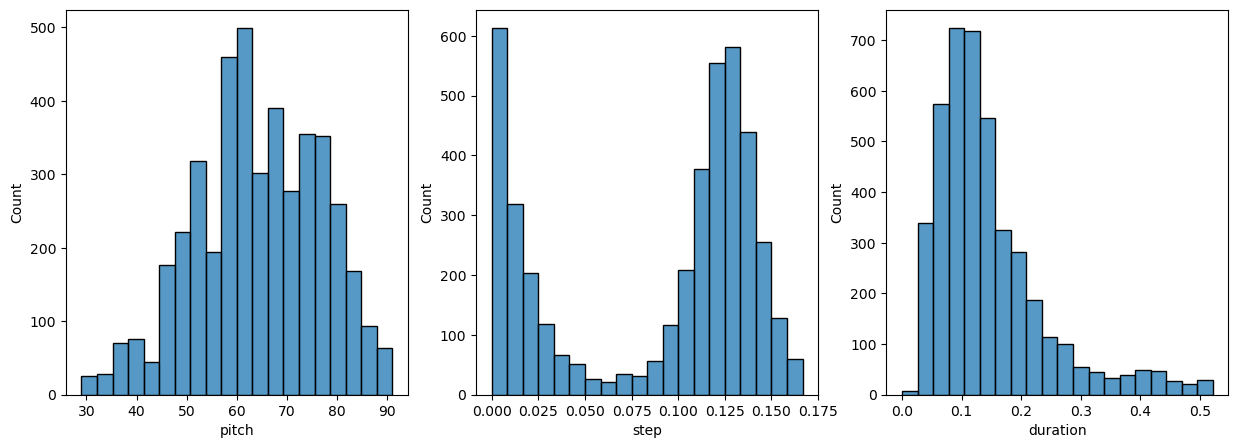

In [19]:
plot_distributions(raw_notes)